# 1. **Introduction to optimization: toy example**

Let's start by looking at the simplest optimization problem possible.

Consider a box with length, width, and depth given by 𝐿, 𝑊, and *H*, respectively. Choose 𝐿, 𝑊, and *H* such that the volume is maximized, subject to the constraint
that the total surface area is equal to 6m^2

Let us first import the library we will use for optimization

In [41]:
!pip install casadi
import casadi as ca

Now, we can initialize the optimizer from casadi, and all the decision variables

In [42]:
opti = ca.Opti()
L = opti.variable()
W = opti.variable()
H = opti.variable()

Defining the constraints

In [43]:
# Total area=6 constraint
opti.subject_to(2*(L*W + W*H + H*L)==6)
# all sides greater than 0
opti.subject_to(L>0)
opti.subject_to(W>0)
opti.subject_to(H>0)


For any optimization problem, we need a objective function/cost function that we need to minimize. Since we are trying to maximize the volume, we minimize -1*volume

In [44]:
volume = L*W*H
opti.minimize(-volume)

Now, we can simply pass our constraints and cost function into the optimizer and ask for a solution. We will be using the "Interior Point Method" solver for the problem. Note that interior point method is a very very big overkill for this optimization example. But we will use that because it is the most common solver used for MPC problems, which we are leading up to.

NOTE: We shall use the commented out version of the solver initialization code, as Casadi just prints too much while solving!

In [45]:
opti.solver('ipopt')

# opti.solver('ipopt', {
#     "ipopt.print_level": 0,  # Suppress IPOPT output
#     "print_time": 0,         # Disable printing the solver time
#     "ipopt.sb": "yes"        # Silent barrier
# })
sol = opti.solve()

# Extracting the solution
L_opt = sol.value(L)
W_opt = sol.value(W)
H_opt = sol.value(H)
V_opt = sol.value(volume)

print(f"Optimal dimensions for maximum volume:")
print(f"L = {L_opt:.4f} m, W = {W_opt:.4f} m, H = {H_opt:.4f} m")
print(f"Maximum Volume = {V_opt:.4f} m³")

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 6.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

That was probably the most complicated way to solve this problem!

But that's okay because we now know how to use casadi :D

# **2. Robot toy example:**

Now, we know how to use Casdi to solve optimization problems.

Just to remind ourselves, let's redefine optimization in simple terms: "Optimization is a method to choose decision variables/control variables in order to minimize a given cost function, subject to some constraints (equality or inequality)."

Now, let us think of a robot that moves on a linear 1D scale.

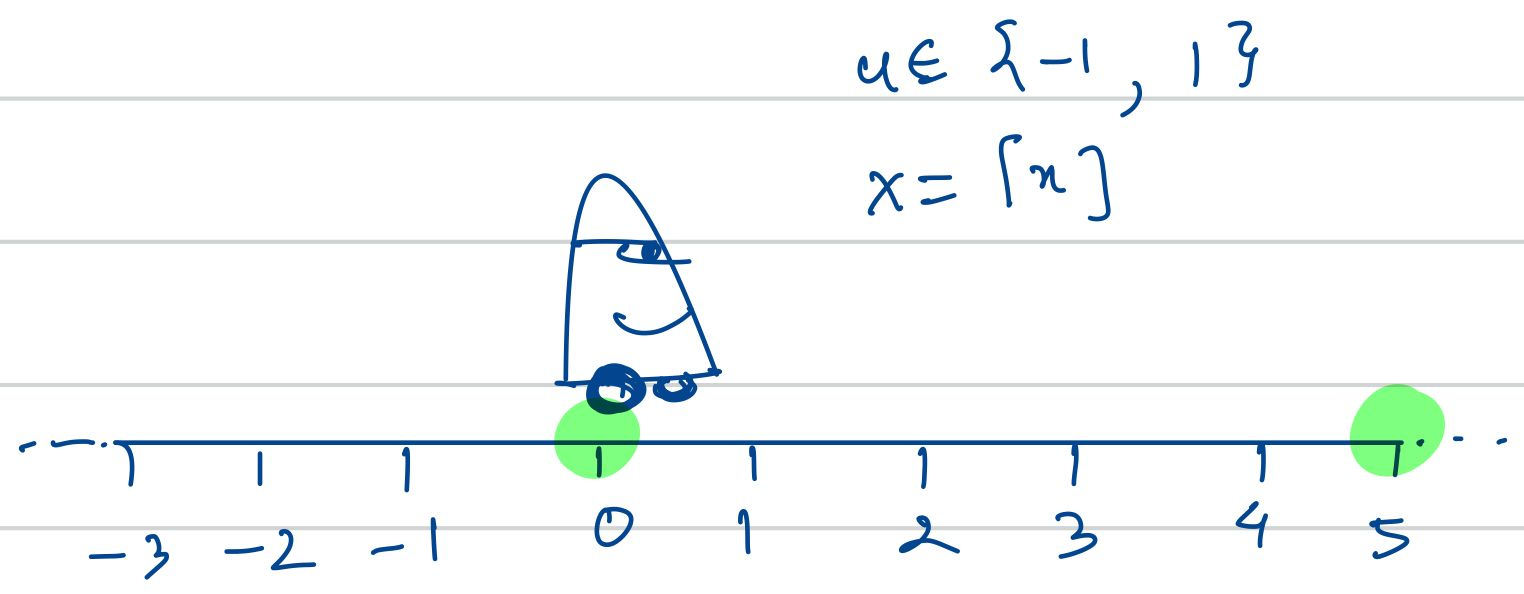

The actions the robot can take are +1 and -1 that moves it in the respective direction on X-axis. The robot starts at 0 and wants to reach goal=5. The other goal of the robot is to use minimum fuel, i.e. minimize control effort.

The state vector of the robot consists of only it's position x.

The robot dynamics can be decribed as follows:

**x[k+1] = x[k] + u[k]**, where k is the time step

Now, the goal of this problem is to find the "optimal" sequence of actions, i.e. decison variables, that will lead the robot from start to goal.

We shall follow a simple algorithm to solve all problems from now:


1.   Initialize any parameters that come with the problem. This could be the mass of the robot, the number of steps, the time step dt, the max and min velocities of the robot etc.
2.   Initialize solver and the variables in the optimization problems, i.e. the states and control variables.
3.   Define the constarints, equality and inequality both. Be sure to include the dynamics of the robot as a part of the inequalitry constraints.
4.   Define the cost function that you want to minimize.
5.   Solve and extract solution!

Let us now follow the above algorithm to help the robot reach it's goal.



In [46]:
# Step 1: Initialize any parameters that come with the problem. This could be the mass of the robot, the number of steps, the time step dt, the max and min velocities of the robot etc.

# number of steps
N = 5

# Step 2: Initialize solver and the variables in the optimization problems, i.e. the states and control variables.

opti = ca.Opti()
X = opti.variable(N+1) # including initial state = state 0
U = opti.variable(N)

# Step 3: Define the constarints, equality and inequality both. Be sure to include the dynamics of the robot as a part of the inequalitry constraints.

# System dynamics constraints
for k in range(N):
    opti.subject_to(X[k+1] == X[k] + U[k])

# Start and goal
opti.subject_to(X[0] == 0)
opti.subject_to(X[N] == 5)

# control u={-1,+1}
# however casadi does not let you define discrete bounds
# we will choose a continous space [-1.0001,1.0001] to make it work the same
opti.subject_to(opti.bounded(-1.0001, U, 1.0001))


# Step 4: Define the cost function that you want to minimize.

# Cost function: Minimize control effort + final position accuracy
cost = ca.sumsqr(U) + 10 * (X[N] - 5)**2
opti.minimize(cost)

# Step 5: Solve and extract solution!
opti.solver('ipopt', {
    "ipopt.print_level": 0,  # Suppress IPOPT output
    "print_time": 0,         # Disable printing the solver time
    "ipopt.sb": "yes"        # Silent barrier
})
sol = opti.solve()
x_opt = sol.value(X)
u_opt = sol.value(U)
print("Optimal X:", x_opt)
print("Optimal U:", u_opt)

Optimal X: [-1.33480293e-35  1.00000000e+00  2.00000000e+00  3.00000000e+00
  4.00000000e+00  5.00000000e+00]
Optimal U: [1. 1. 1. 1. 1.]


That's awesome! We have helped the robot reach it's goal.

The solution here was again very obvious. But this problem gave us a good intuition about how we can tackle control and planning problem in robotics.

# 3. **2D navigation using unicycle model:**

Now, let us try to do robot planning and control in a more realistic scenario. Consider a robot that uses unicycle model to move about it's surroundings. It has to start at (0,0) and reach (5,5). Now the state soace and control space is going to be continous within the bounds of the environment.

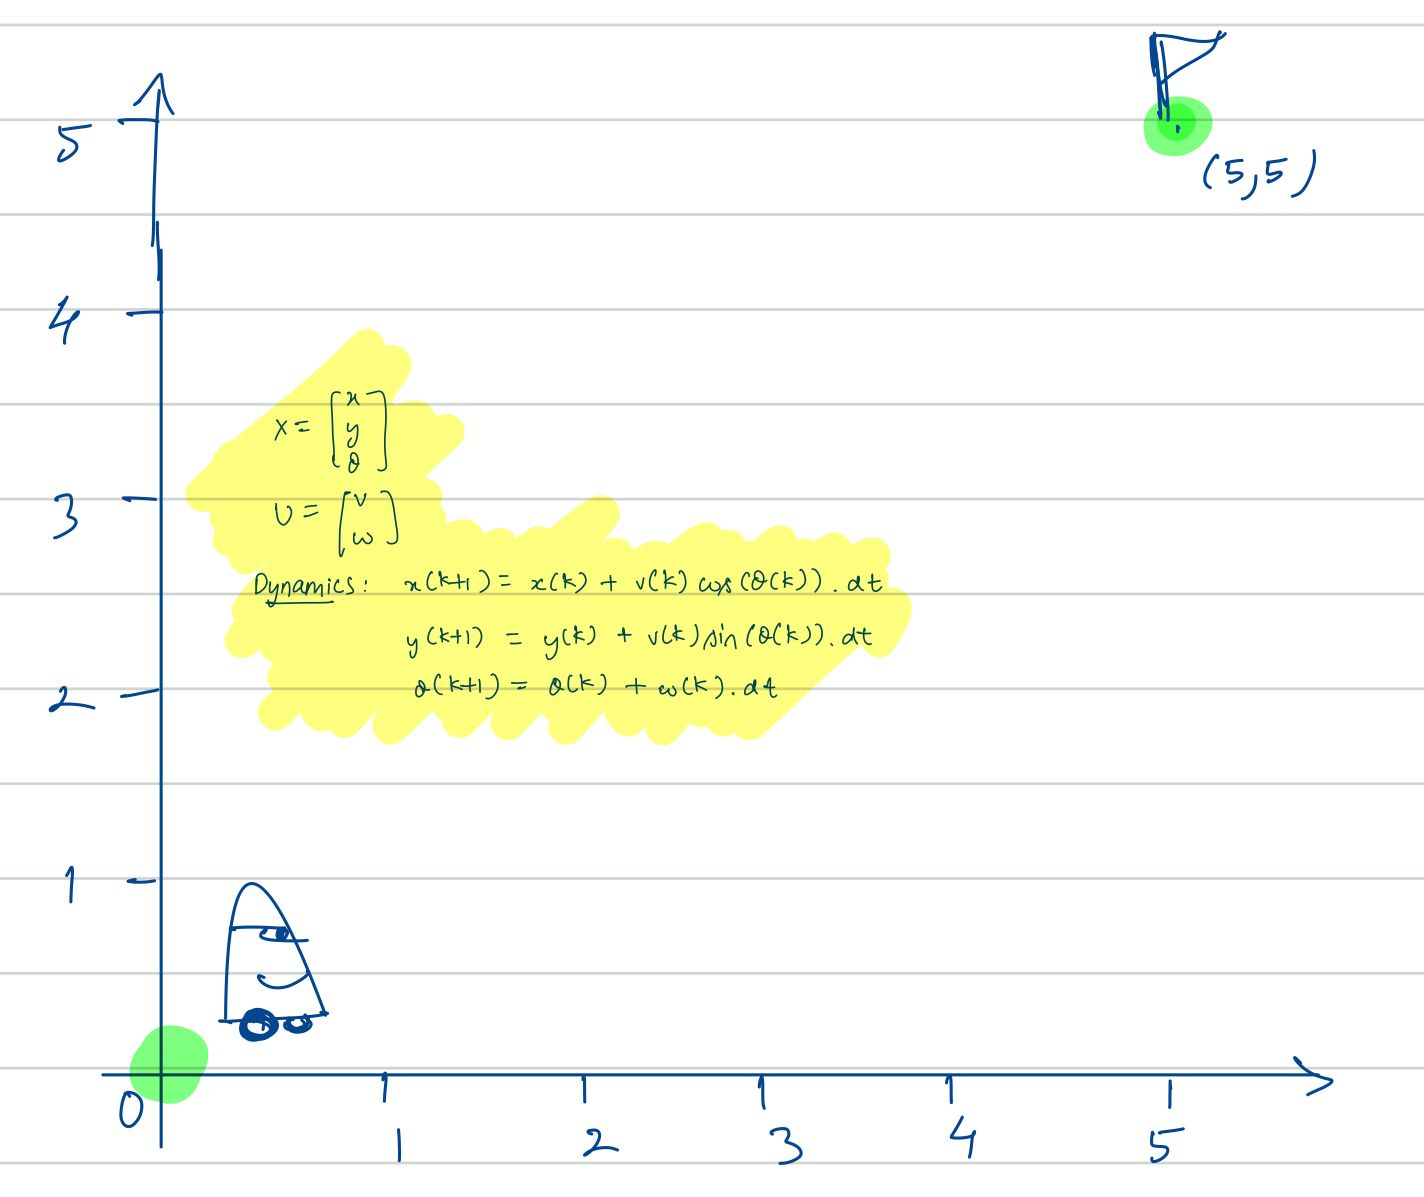


Let us now define the cost function:
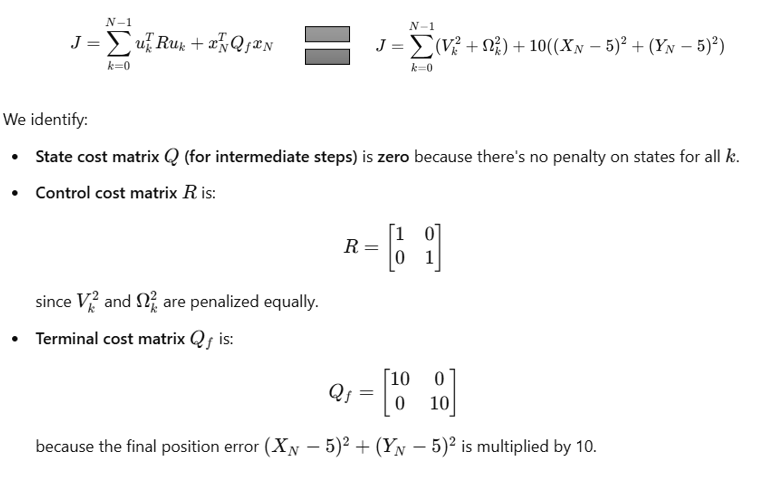

We are putting penalty on the control effort and the final state of the robot. This formulation is termed as **QP**.

We are now ready to solve this problem using the same algorithm we defined in the previous problem.

In [47]:
# Step 1

dt = 1.0
N = 10 # prediction horizon
start = [0, 0]
goal = [5, 5]
vmin = 0
vmax = 2
wmin = -1
wmax = 1

# Step 2
X = opti.variable(N+1)  # x position
Y = opti.variable(N+1)  # y position
Theta = opti.variable(N+1)  # heading angle
V = opti.variable(N)  # Linear velocity (control)
Omega = opti.variable(N)  # Angular velocity (control)

# Step 3

# unicycle model dynamics constraint
for k in range(N):
    opti.subject_to(X[k+1] == X[k] + V[k] * ca.cos(Theta[k]) * dt)
    opti.subject_to(Y[k+1] == Y[k] + V[k] * ca.sin(Theta[k]) * dt)
    opti.subject_to(Theta[k+1] == Theta[k] + Omega[k] * dt)

# start and goal constraints
opti.subject_to(X[0] == start[0])
opti.subject_to(Y[0] == start[1])
opti.subject_to(Theta[0] == 0)  # Start facing x-axis

# Goal condition
opti.subject_to(X[N] == goal[0])
opti.subject_to(Y[N] == goal[1])

# Control constraints
opti.subject_to(opti.bounded(vmin, V, vmax))  # 0 ≤ v ≤ 2
opti.subject_to(opti.bounded(wmin, Omega, wmax))  # -1 ≤ omega ≤ 1

# Step 4

cost = ca.sumsqr(V) + ca.sumsqr(Omega) + 10 * ((X[N] - 5)**2 + (Y[N] - 5)**2)
opti.minimize(cost)

# Step 5
opti.solver('ipopt', {
    "ipopt.print_level": 0,  # Suppress IPOPT output
    "print_time": 0,         # Disable printing the solver time
    "ipopt.sb": "yes"        # Silent barrier
})
sol = opti.solve()

# Extract solution
x_opt = sol.value(X)
y_opt = sol.value(Y)
theta_opt = sol.value(Theta)
v_opt = sol.value(V)
omega_opt = sol.value(Omega)

As this problem is in continous space, it will be difficult to visualize the solution by just printing. We can instead use matplotlib for help.

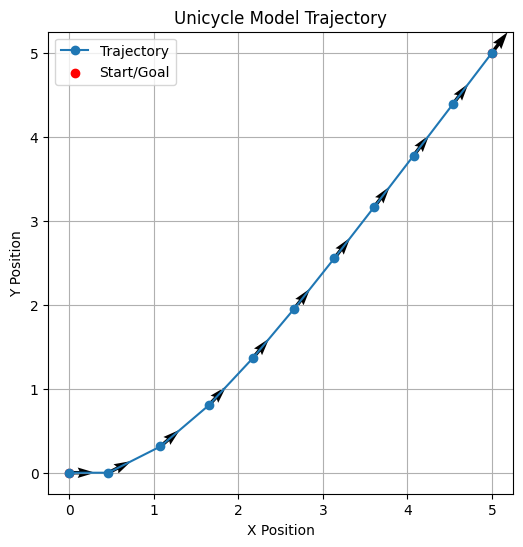

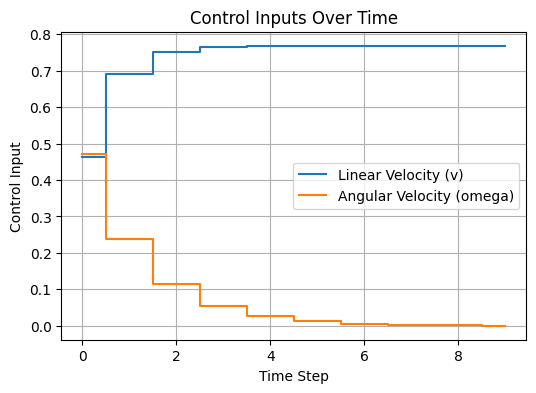

In [48]:
import numpy as np
import matplotlib.pyplot as plt


# Plot results
plt.figure(figsize=(6,6))
plt.plot(x_opt, y_opt, 'o-', label="Trajectory")
plt.scatter([0, 5], [0, 5], color='red', label="Start/Goal")
plt.quiver(x_opt, y_opt, np.cos(theta_opt), np.sin(theta_opt))
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()
plt.title("Unicycle Model Trajectory")
plt.show()

plt.figure(figsize=(6,4))
plt.step(range(N), v_opt, label="Linear Velocity (v)", where="mid")
plt.step(range(N), omega_opt, label="Angular Velocity (omega)", where="mid")
plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.legend()
plt.grid()
plt.title("Control Inputs Over Time")
plt.show()


# 4. Time to face obstacles!

We got great results using casadi to solve our QP problem in the previous section. However, we are going to face obstacles in the real world. Our robot cannot simply head towards the goal without checking for collisions.

Let us place two circular obstacles of radii 0.5 and 0.75 at the positions shown below:
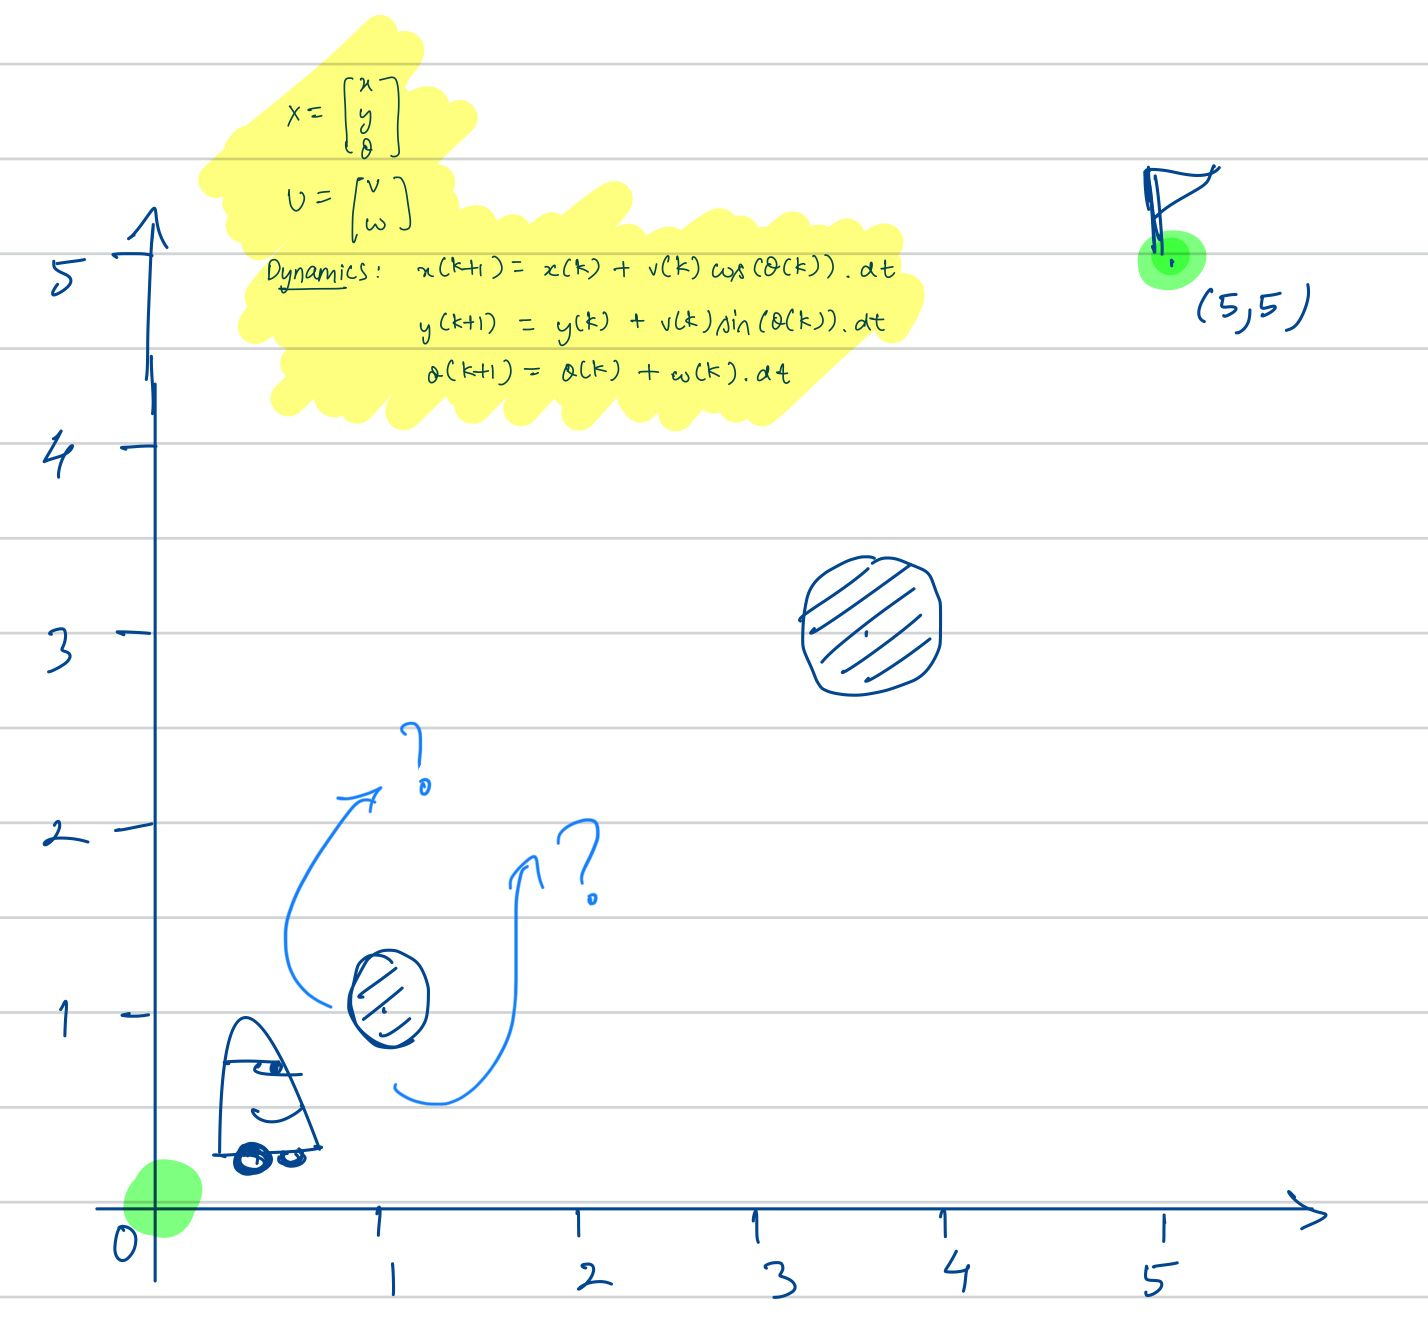

The way to tackle obstacles is by adding an inequality constarint usung the euclidian distance between the robot state and the obstacle.
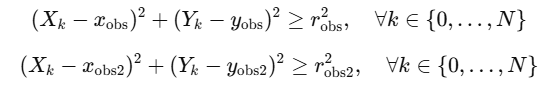

Let us add the above constraint and solve again.


In [49]:
# Step 1 modification
obs_x, obs_y, obs_r = 3.5, 3, 0.75  # Obstacle center and radius
obs2_x, obs2_y, obs2_r = 1, 1.0, 0.5  # Obstacle center and radius
safety_margin = 0.1

# Step 3 modification
# Obstacle avoidance constraint: Stay outside the circles
for k in range(N+1):
    opti.subject_to((X[k] - obs_x)**2 + (Y[k] - obs_y)**2 >= (obs_r + safety_margin)**2)
    opti.subject_to((X[k] - obs2_x)**2 + (Y[k] - obs2_y)**2 >= (obs2_r + safety_margin)**2)


# Step 5
opti.solver('ipopt', {
    "ipopt.print_level": 0,  # Suppress IPOPT output
    "print_time": 0,         # Disable printing the solver time
    "ipopt.sb": "yes"        # Silent barrier
})
sol = opti.solve()

x_opt = sol.value(X)
y_opt = sol.value(Y)
theta_opt = sol.value(Theta)

Let us try to visualize the result as an animation this time.

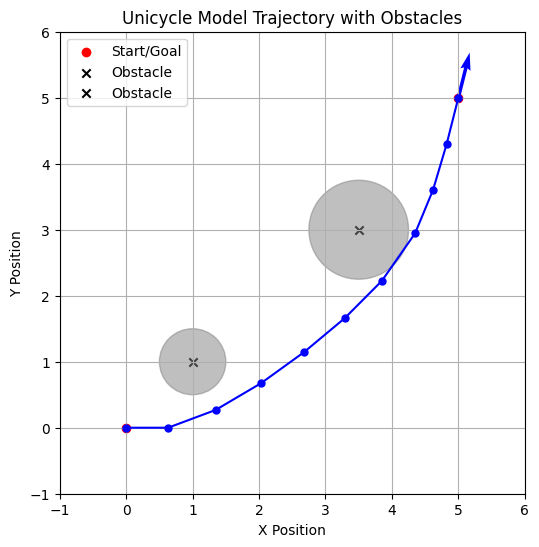

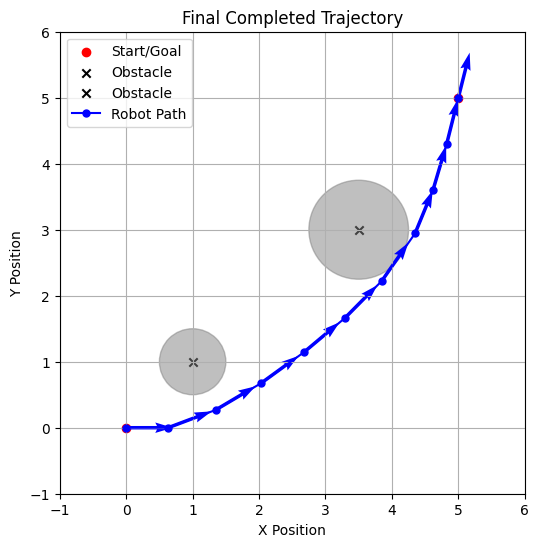

In [50]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Initialize figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot static elements
ax.scatter([0, 5], [0, 5], color='red', label="Start/Goal")
ax.scatter(obs_x, obs_y, color='black', marker='x', label="Obstacle")
ax.scatter(obs2_x, obs2_y, color='black', marker='x', label="Obstacle")
circle1 = plt.Circle((obs_x, obs_y), obs_r, color='gray', alpha=0.5)
circle2 = plt.Circle((obs2_x, obs2_y), obs2_r, color='gray', alpha=0.5)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend()
ax.grid()
ax.set_title("Unicycle Model Trajectory with Obstacles")

# Plot robot trajectory (initial frame)
robot, = ax.plot([], [], 'bo-', markersize=5, label="Robot")
arrow = ax.quiver([], [], [], [], scale=10, color='blue')  # Arrow for heading

# Animation update function
def update(frame):
    robot.set_data(x_opt[:frame+1], y_opt[:frame+1])

    # Update quiver arrow to show heading
    arrow.set_offsets([[x_opt[frame], y_opt[frame]]])
    arrow.set_UVC([np.cos(theta_opt[frame])], [np.sin(theta_opt[frame])])
    return robot, arrow

# Create animation
ani = FuncAnimation(fig, update, frames=N+1, interval=200, blit=False, repeat=False)

# Display animation in Google Colab
HTML(ani.to_jshtml())


# ==== Static Plot of the Final Trajectory ====
plt.figure(figsize=(6, 6))
plt.scatter([0, goal[0]], [0, goal[1]], color='red', label="Start/Goal")
plt.scatter(obs_x, obs_y, color='black', marker='x', label="Obstacle")
plt.scatter(obs2_x, obs2_y, color='black', marker='x', label="Obstacle")
circle1_static = plt.Circle((obs_x, obs_y), obs_r, color='gray', alpha=0.5)
circle2_static = plt.Circle((obs2_x, obs2_y), obs2_r, color='gray', alpha=0.5)
plt.gca().add_patch(circle1_static)
plt.gca().add_patch(circle2_static)
plt.plot(x_opt, y_opt, 'bo-', markersize=5, label="Robot Path")  # Completed trajectory
plt.quiver(x_opt, y_opt, np.cos(theta_opt), np.sin(theta_opt), scale=10, color='blue')  # Heading arrows
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()
plt.title("Final Completed Trajectory")
plt.show()

# 5. **Model Predictive Control:**

The above solution somewhat works. But you must have observed 2 things:


1.   The time step dt between 2 waypoints is too small. This causes the robot to possibly collide between 2 states it thinks is optimum.
2.   There is no feedback!! The robot is computing a sequence of control signals to take from start to end and trusting the sequence throughout it's actual motion.

This raises the need for MPC. In very very simple layman terms, let us try to define Model Predictive Control: "Solve optimal control problems (like the QP problem we just solved) for a small window of time in the future, but only take the first control action. After moving one time step (applying action model), recompute the solution to your optimal problem again. Repeat till you reach the goal."

Let us modify the algorithm we defined in the above section using probably the most unscientific, but simple explaination of MPC we just saw.

In [51]:
# Step 1

dt = 0.05 # more realistic time step
N = 10
obs_x, obs_y, obs_r = 3.5, 3, 0.75
obs2_x, obs2_y, obs2_r = 1, 1.0, 0.5
reached_goal_threshold = 0.1
vmin = 0
vmax = 2
wmin = -1
wmax = 1
goal_x, goal_y = 5, 5
max_iters = 100  # Max iterations to reach the goal
safety_margin = 0.1


# Step 2-5 in a loop using a function called "solve_mpc()"
def solve_mpc(x0, y0, theta0):
    # initial state to "solve_mpc()" is actually current state of the robot
    opti = ca.Opti()
    X = opti.variable(N+1)
    Y = opti.variable(N+1)
    Theta = opti.variable(N+1)
    V = opti.variable(N)
    Omega = opti.variable(N)

    # unicycle model dynamics
    for k in range(N):
        opti.subject_to(X[k+1] == X[k] + V[k] * ca.cos(Theta[k]) * dt)
        opti.subject_to(Y[k+1] == Y[k] + V[k] * ca.sin(Theta[k]) * dt)
        opti.subject_to(Theta[k+1] == Theta[k] + Omega[k] * dt)

    # current state
    opti.subject_to(X[0] == x0)
    opti.subject_to(Y[0] == y0)
    opti.subject_to(Theta[0] == theta0)

    # Obstacle avoidance constraints with safety margin
    for k in range(N+1):
        opti.subject_to((X[k] - obs_x)**2 + (Y[k] - obs_y)**2 >= (obs_r + safety_margin)**2)
        opti.subject_to((X[k] - obs2_x)**2 + (Y[k] - obs2_y)**2 >= (obs2_r + safety_margin)**2)

    # Control constraints
    opti.subject_to(opti.bounded(vmin, V, vmax))
    opti.subject_to(opti.bounded(wmin, Omega, wmax))

    # Cost function: Higher weight on reaching goal
    goal_weight = 150
    effort_weight = 0.5
    cost = effort_weight * (ca.sumsqr(V) + ca.sumsqr(Omega)) + goal_weight * ((X[N] - goal_x)**2 + (Y[N] - goal_y)**2)
    opti.minimize(cost)

    # Solve
    opti.solver('ipopt', {
        "ipopt.print_level": 0,  # Suppress IPOPT output
        "print_time": 0,         # Disable printing the solver time
        "ipopt.sb": "yes"        # Silent barrier
    })
    sol = opti.solve()
    # Return only the first control action
    return sol.value(V[0]), sol.value(Omega[0])

# Variables to save the states taken by the MPC controller
x_traj, y_traj, theta_traj = [], [], []
x, y, theta = 0, 0, 0  # Initial state


# MPC controller that runs in a loop
for _ in range(max_iters):
    v_opt, omega_opt = solve_mpc(x, y, theta)

    x += v_opt * np.cos(theta) * dt
    y += v_opt * np.sin(theta) * dt
    theta += omega_opt * dt

    # Store trajectory
    x_traj.append(x)
    y_traj.append(y)
    theta_traj.append(theta)

    # Stop if close to goal
    if np.linalg.norm([x - goal_x, y - goal_y]) < reached_goal_threshold:
        break

Plotting the MPC result.

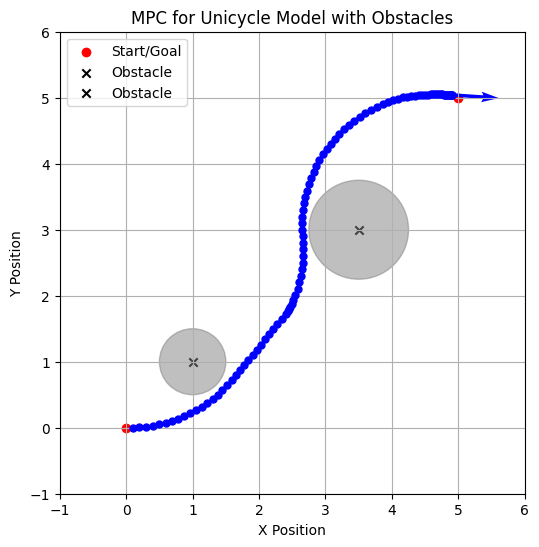

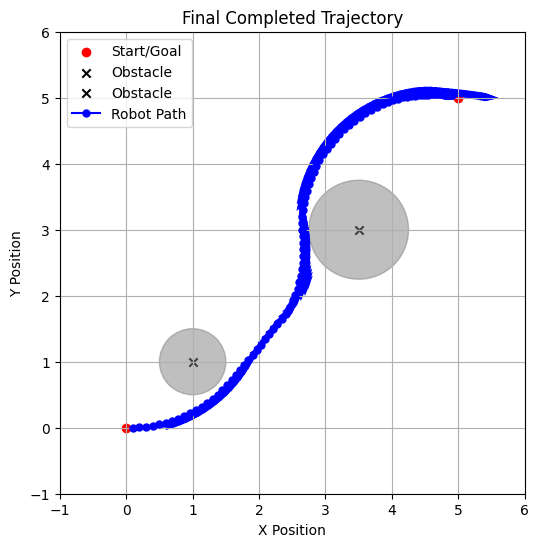

In [52]:
# Plot results
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter([0, goal_x], [0, goal_y], color='red', label="Start/Goal")
ax.scatter(obs_x, obs_y, color='black', marker='x', label="Obstacle")
ax.scatter(obs2_x, obs2_y, color='black', marker='x', label="Obstacle")
circle1 = plt.Circle((obs_x, obs_y), obs_r, color='gray', alpha=0.5)
circle2 = plt.Circle((obs2_x, obs2_y), obs2_r, color='gray', alpha=0.5)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend()
ax.grid()
ax.set_title("MPC for Unicycle Model with Obstacles")

# Plot robot trajectory
robot, = ax.plot([], [], 'bo-', markersize=5, label="Robot")
arrow = ax.quiver([], [], [], [], scale=10, color='blue')

def update(frame):
    robot.set_data(x_traj[:frame+1], y_traj[:frame+1])
    arrow.set_offsets([[x_traj[frame], y_traj[frame]]])
    arrow.set_UVC([np.cos(theta_traj[frame])], [np.sin(theta_traj[frame])])
    return robot, arrow

ani = FuncAnimation(fig, update, frames=len(x_traj), interval=200, blit=False, repeat=False)
# Display animation in Google Colab
HTML(ani.to_jshtml())

# ==== Static Plot of the Final Trajectory ====
plt.figure(figsize=(6, 6))
plt.scatter([0, goal_x], [0, goal_y], color='red', label="Start/Goal")
plt.scatter(obs_x, obs_y, color='black', marker='x', label="Obstacle")
plt.scatter(obs2_x, obs2_y, color='black', marker='x', label="Obstacle")
circle1_static = plt.Circle((obs_x, obs_y), obs_r, color='gray', alpha=0.5)
circle2_static = plt.Circle((obs2_x, obs2_y), obs2_r, color='gray', alpha=0.5)
plt.gca().add_patch(circle1_static)
plt.gca().add_patch(circle2_static)
plt.plot(x_traj, y_traj, 'bo-', markersize=5, label="Robot Path")  # Completed trajectory
plt.quiver(x_traj, y_traj, np.cos(theta_traj), np.sin(theta_traj), scale=10, color='blue')  # Heading arrows
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()
plt.title("Final Completed Trajectory")
plt.show()

That worked!! And it was more realistic!

# 6. More realistic?

The method discussed in the above section is called **MPC-DC** where "DC" refers to "distance constraints". While this method of planning and control works in many scenarios, there are a few limitations we can try to solve in our next method:

-  The safety constraints defined in the above problem formulation is on the state of the robot: "X". Will we get more robust results if we put constraints on the control variables: "U"?
-  We considered the safe region that the robot has to stay in by considernig the distance from the center of the circular obstacle. What about the speed of approach towards these obstacles?
-  Do we always know all obstacles beforehand?
-  Is this optimization method applicable to a unicycle model 2D robot only? Or can we extend it to other kinds of robots?